In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [8]:
N = 300
K = 3
D = 2

## Model Parameters
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'gibbs-z'

gpu = torch.device('cuda:1')

In [9]:
Xs = torch.from_numpy(np.load('rings_dataset/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('rings_dataset/obs_mu.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [10]:
class Enc_z(nn.Module):
    def __init__(self, num_hidden=2*D,
                       sample_size=SAMPLE_SIZE,
                       batch_size=BATCH_SIZE):
        super(self.__class__, self).__init__()
        self.difference = nn.Sequential(
            nn.Linear(2*D, int(0.5*num_hidden)))
        
#         self.pi_prob = nn.Sequential(
#             nn.Linear(1+D, num_hidden),
#             nn.Tanh(),
#             nn.Linear(num_hidden, int(0.5*num_hidden)),
#             nn.Tanh(),
#             nn.Linear(int(0.5*num_hidden), 1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        self.radius = torch.ones((sample_size, batch_size, N, 1)) *  1.5
#         self.noise_sigma = torch.ones((sample_size, batch_size, N, D)) *  0.05
        if CUDA:
            self.prior_pi = self.prior_pi.cuda().to(gpu)
            self.radius = self.radius.cuda().to(gpu)
#             self.noise_sigma = self.noise_sigma.cuda().to(gpu)
  
    def forward(self, obs, obs_mu, sample_size, batch_size):
        obs_mu_c1 = obs_mu[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c2 = obs_mu[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c3 = obs_mu[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)
        
        dis_c1 = (self.difference(torch.cat((obs, obs_mu_c1), -1)) ** 2).sum(-1).sqrt()
        dis_c2 = (self.difference(torch.cat((obs, obs_mu_c2), -1)) ** 2).sum(-1).sqrt()
        dis_c3 = (self.difference(torch.cat((obs, obs_mu_c3), -1)) ** 2).sum(-1).sqrt()
        
#         ## S * B * N * (1+D) --> S * B * N * 1
#         z_pi_c1 = self.pi_prob(torch.cat((self.radius - dis_c1, self.noise_sigma), -1) )
#         z_pi_c2 = self.pi_prob(torch.cat((self.radius - dis_c2, self.noise_sigma), -1) )
#         z_pi_c3 = self.pi_prob(torch.cat((self.radius - dis_c3, self.noise_sigma), -1) )
        distance = torch.cat((dis_c1.unsqueeze(-1), dis_c2.unsqueeze(-1), dis_c3.unsqueeze(-1)), -1) # S * B * N * K
        obs_dist = Normal(torch.ones(1).cuda().to(gpu) * 1.5, torch.ones(1).cuda().to(gpu) * 0.05)
        log_distance = obs_dist.log_prob(distance) / (2*math.pi*distance)# S * B * N * K   

        q_pi = F.softmax(log_distance, -1)
        
        q = probtorch.Trace()
        p = probtorch.Trace()
        
        z = cat(q_pi).sample()
        _ = q.variable(cat, probs=q_pi, value=z, name='zs')
        _ = p.variable(cat, probs=self.prior_pi, value=z, name='zs')
        return q, p
    
def initialize():
    enc_z = Enc_z()
    if CUDA:
        enc_z.cuda().to(gpu)
    optimizer =  torch.optim.Adam(list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_z, optimizer

In [11]:
enc_z, optimizer = initialize()

In [12]:
def Eubo(enc_z, obs, obs_mu, N, K, D, sample_size, batch_size, gpu):
    q_z, p_z = enc_z(obs, obs_mu, sample_size, batch_size)
    log_p_z = p_z['zs'].log_prob
    log_q_z = q_z['zs'].log_prob ## S * B * N
    states = q_z['zs'].value
    log_obs_n = True_Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=False)
    log_weights_local = log_obs_n + log_p_z - log_q_z
    weights_local = F.softmax(log_weights_local, 0).detach()

    eubo =(weights_local * log_weights_local).sum(0).sum(-1).mean()
    elbo = log_weights_local.sum(-1).mean()
    ess = (1. / (weights_local**2).sum(0)).mean()
    return eubo, elbo, ess

In [13]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs_mu = OBS_MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
            obs_mu = obs_mu.cuda().to(gpu)
        eubo, elbo, ess = Eubo(enc_z, obs, obs_mu, N, K, D, SAMPLE_SIZE, BATCH_SIZE, gpu)
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))

epoch=0, EUBO=-6658.811, ELBO=-9455.630, ESS=8.182 (0s)
epoch=1, EUBO=-5258.263, ELBO=-8438.704, ESS=7.777 (0s)
epoch=2, EUBO=-4227.502, ELBO=-7443.664, ESS=7.624 (0s)
epoch=3, EUBO=-3538.372, ELBO=-6415.454, ESS=7.697 (0s)
epoch=4, EUBO=-3110.662, ELBO=-5548.140, ESS=7.924 (0s)
epoch=5, EUBO=-2783.669, ELBO=-4895.238, ESS=8.118 (0s)
epoch=6, EUBO=-2479.298, ELBO=-4371.960, ESS=8.287 (0s)
epoch=7, EUBO=-2315.888, ELBO=-4050.423, ESS=8.434 (0s)
epoch=8, EUBO=-2247.901, ELBO=-3791.091, ESS=8.575 (0s)
epoch=9, EUBO=-2240.250, ELBO=-3512.180, ESS=8.735 (0s)
epoch=10, EUBO=-2157.435, ELBO=-3201.457, ESS=8.867 (0s)
epoch=11, EUBO=-2025.772, ELBO=-2882.863, ESS=8.963 (0s)
epoch=12, EUBO=-1775.623, ELBO=-2469.117, ESS=9.053 (0s)
epoch=13, EUBO=-1522.514, ELBO=-2075.565, ESS=9.139 (0s)
epoch=14, EUBO=-1340.578, ELBO=-1766.062, ESS=9.214 (0s)
epoch=15, EUBO=-997.857, ELBO=-1290.750, ESS=9.264 (0s)
epoch=16, EUBO=-338.747, ELBO=-454.020, ESS=9.342 (0s)
epoch=17, EUBO=-245.774, ELBO=-281.924, ESS=

KeyboardInterrupt: 

CPU times: user 1.72 s, sys: 11.2 ms, total: 1.73 s
Wall time: 1.73 s


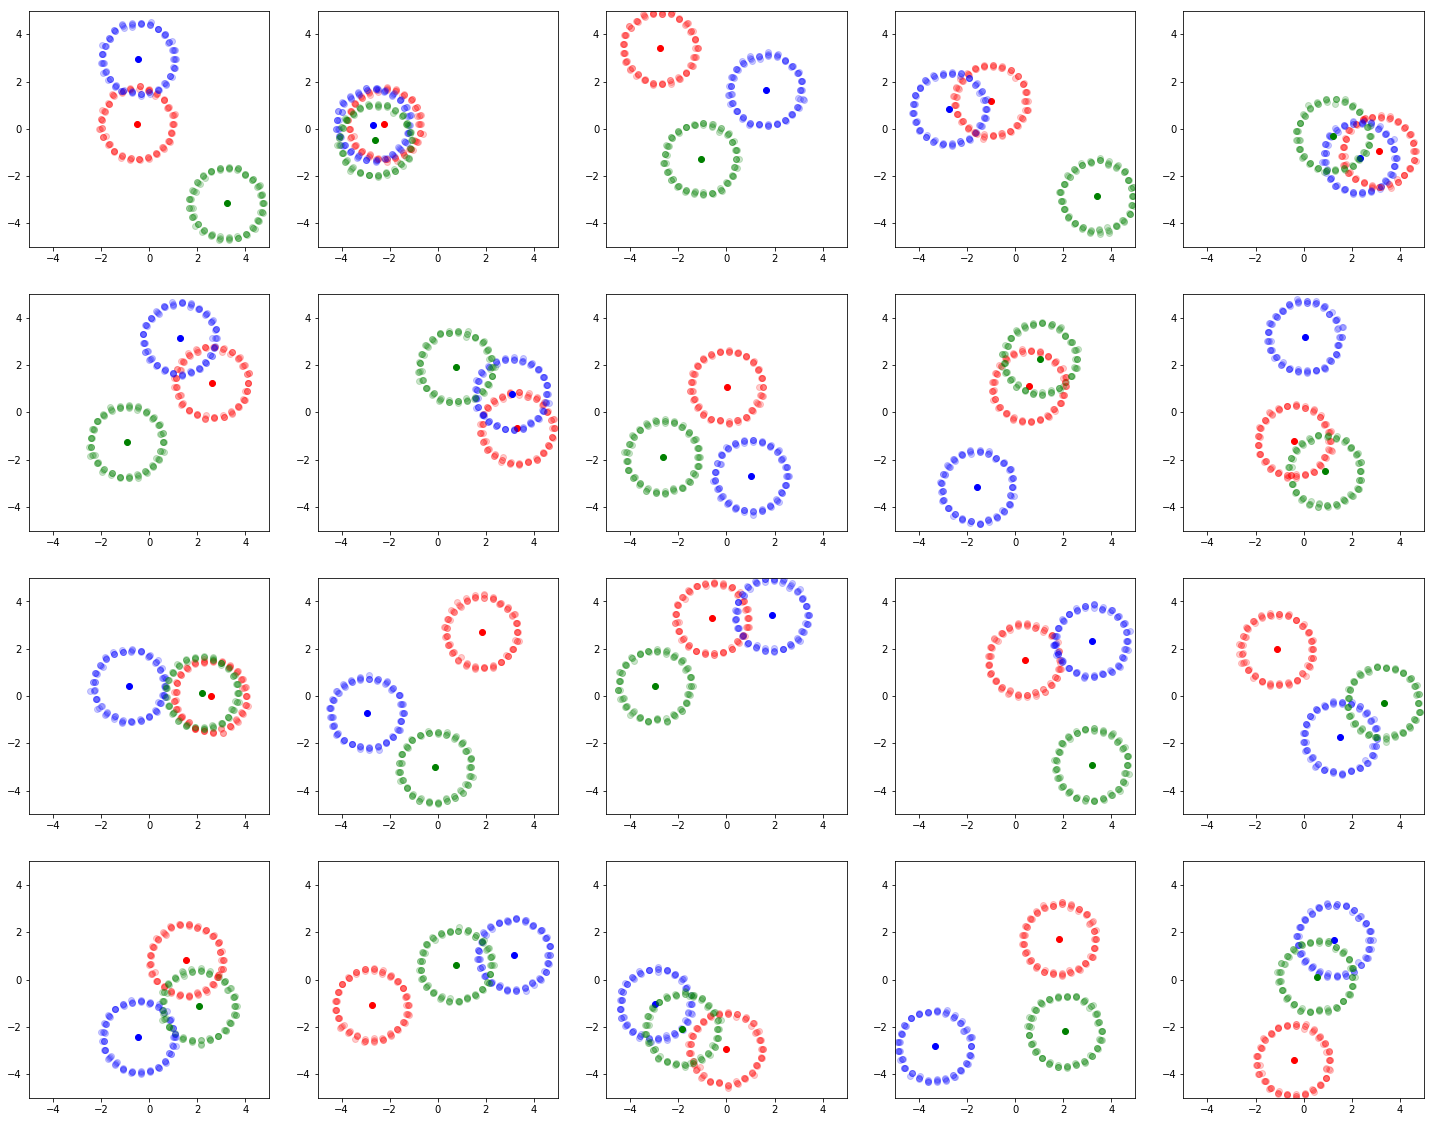

In [16]:
BATCH_SIZE_TEST = 20

def sample_single_batch(num_seqs, Xs, OBS_MU, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs_mu = OBS_MU[batch_indices].repeat(sample_size, 1, 1, 1)
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
        obs_mu = obs_mu.cuda().to(gpu)
    return obs, obs_mu

def test(enc_z, obs, obs_mu, sample_size, batch_size):
        ## update z -- cluster assignments
    q_z, p_z = enc_z(obs, obs_mu, sample_size, batch_size)
    return q_z

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,20))
    xs = obs[0].cpu().data.numpy()
    mu = obs_mu[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_b = mu[b]
        assignments = z.argmax(-1)
        for k in range(K):
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            ax.scatter(mu_b[k, 0], mu_b[k, 1], c=colors[k])
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs, obs_mu = sample_single_batch(NUM_SEQS, Xs, OBS_MU, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
q_z = test(enc_z, obs, obs_mu, SAMPLE_SIZE, BATCH_SIZE_TEST)
%time plot_samples(obs, obs_mu, q_z, K, BATCH_SIZE_TEST, PATH)